In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')
df.head()

,age,height_cm,weight_kgs,nationality,overall_rating,preferred_foot,weak_foot(1-5),skill_moves(1-5),crossing,finishing,...,positions_GK,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST
0,27.0,177.606642,76.2,Denmark,88,1,5,4.0,88,81,...,0,0,0,0,0,0,1,0,0,0
1,25.0,190.500000,83.9,France,88,1,4,4.5,80,75,...,0,0,0,0,0,0,0,0,0,0
2,27.0,162.560000,59.0,Italy,88,1,4,4.0,86,77,...,0,0,0,1,0,0,0,0,0,1
3,27.0,187.960000,88.9,Senegal,88,1,3,2.0,30,22,...,0,0,0,0,0,0,0,0,0,0
4,27.0,193.040000,92.1,Netherlands,88,1,3,2.0,53,52,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [17]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
BATCH_SIZE = 256

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=RANDOM_STATE
)

In [18]:
from category_encoders import TargetEncoder

te = TargetEncoder(cols='nationality')
X_train['nationality'] = te.fit_transform(X_train['nationality'], y_train)
X_val['nationality'] = te.transform(X_val['nationality'])
X_test['nationality'] = te.transform(X_test['nationality'])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
print(f"Số mẫu trong tập train: {len(train_loader.dataset)}")
print(f"Số mẫu trong tập val: {len(val_loader.dataset)}")
print(f"Số mẫu trong tập test: {len(test_loader.dataset)}\n")

for batch_idx, (data, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Dữ liệu: {data.shape}")    # Ví dụ: torch.Size([64, số_đặc_trưng])
    print(f" - Nhãn: {targets.shape}")    # Ví dụ: torch.Size([64])
    break

Số mẫu trong tập train: 12562
Số mẫu trong tập val: 2692
Số mẫu trong tập test: 2693

Batch 1:
 - Dữ liệu: torch.Size([256, 52])
 - Nhãn: torch.Size([256])


In [21]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    y_true = []
    y_pred = []

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)  # Đảm bảo nhãn có kích thước (batch_size, 1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)  # nhân với số mẫu trong batch
        
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(outputs.cpu().detach().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    epoch_r2 = r2_score(y_true, y_pred)
    epoch_mae = mean_absolute_error(y_true, y_pred)
    return epoch_loss, epoch_r2, epoch_mae

In [22]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device).unsqueeze(1)

            outputs = model(inputs)

            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().detach().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return epoch_loss, r2, mae

In [23]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
        )
        self.sc1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
        )
        # self.sc2 = nn.Sequential(
        #     nn.Linear(256, 256),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(256),
        # )
        self.fc = nn.Linear(256, 1)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        prev_x = x
        x = self.layer1(x)
        x += self.sc1(prev_x)
        prev_x = x
        x = self.layer2(x)
        # x += self.sn2(prev_x)
        x += prev_x
        x = self.layer3(x)
        x = self.fc(x)
        return x

In [24]:
import torchsummary

input_dim = X_train.shape[1]
model = MLPRegressor(input_dim).to(device)

torchsummary.summary(model, (input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          13,568
              ReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          13,568
              ReLU-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
            Linear-8                  [-1, 256]          65,792
              ReLU-9                  [-1, 256]               0
      BatchNorm1d-10                  [-1, 256]             512
          Dropout-11                  [-1, 256]               0
           Linear-12                  [-1, 256]          65,792
             ReLU-13                  [-1, 256]               0
      BatchNorm1d-14                  [

In [25]:
model = MLPRegressor(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [26]:
NUM_EPOCHS = 150

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

train_losses, train_r2s = [], []
val_losses, val_r2s = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_r2, _ = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_loss, val_r2, _ = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_r2s.append(train_r2)
    val_losses.append(val_loss)
    val_r2s.append(val_r2)

    scheduler.step()

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] | Train Loss: {train_loss:.4f} | Train R2: {train_r2:.4f} | Val Loss: {val_loss:.4f} | Val R²: {val_r2:.4f}")


Epoch [1/150] | Train Loss: 4320.4388 | Train R2: -88.2799 | Val Loss: 4129.5703 | Val R²: -87.1663
Epoch [2/150] | Train Loss: 3971.4033 | Train R2: -81.0673 | Val Loss: 3659.4503 | Val R²: -77.1292
Epoch [3/150] | Train Loss: 3358.3197 | Train R2: -68.3982 | Val Loss: 2943.5393 | Val R²: -61.8445
Epoch [4/150] | Train Loss: 2594.9366 | Train R2: -52.6232 | Val Loss: 2209.3218 | Val R²: -46.1690
Epoch [5/150] | Train Loss: 1831.7834 | Train R2: -36.8530 | Val Loss: 1482.3481 | Val R²: -30.6481
Epoch [6/150] | Train Loss: 1181.3942 | Train R2: -23.4130 | Val Loss: 900.8657 | Val R²: -18.2335
Epoch [7/150] | Train Loss: 696.5095 | Train R2: -13.3931 | Val Loss: 500.7951 | Val R²: -9.6920
Epoch [8/150] | Train Loss: 376.2053 | Train R2: -6.7741 | Val Loss: 246.5942 | Val R²: -4.2648
Epoch [9/150] | Train Loss: 188.7531 | Train R2: -2.9005 | Val Loss: 120.7605 | Val R²: -1.5782
Epoch [10/150] | Train Loss: 88.8654 | Train R2: -0.8364 | Val Loss: 57.2908 | Val R²: -0.2232
Epoch [11/150] | 

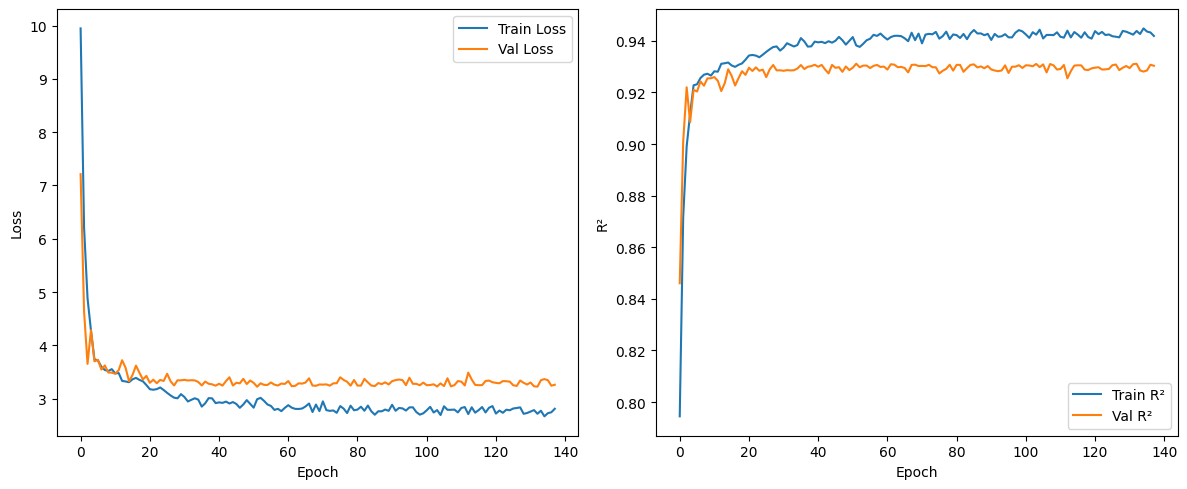

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses[12:], label='Train Loss')
plt.plot(val_losses[12:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_r2s[12:], label='Train R²')
plt.plot(val_r2s[12:], label='Val R²')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
print("Training Set")
train_loss, train_r2, train_mae = evaluate(model, train_loader, criterion, device)
print(f"Loss: {train_loss:.4f} | R²: {train_r2:.4f} | MAE: {train_mae:.4f}")

print("\nValidation Set")
val_loss, val_r2, val_mae = evaluate(model, val_loader, criterion, device)
print(f"Loss: {val_loss:.4f} | R²: {val_r2:.4f} | MAE: {val_mae:.4f}")

print("\nTest Set")
test_loss, test_r2, test_mae = evaluate(model, test_loader, criterion, device)
print(f"Loss: {test_loss:.4f} | R²: {test_r2:.4f} | MAE: {test_mae:.4f}")

Training Set
Loss: 1.9886 | R²: 0.9589 | MAE: 0.7679

Validation Set
Loss: 3.2623 | R²: 0.9304 | MAE: 1.1388

Test Set
Loss: 3.2873 | R²: 0.9335 | MAE: 1.1172


In [29]:
print("Training Set")
train_loss, train_r2, train_mae = evaluate(model, train_loader, criterion, device)
print(f"Loss: {train_loss:.4f} | R²: {train_r2:.4f} | MAE: {train_mae:.4f}")

print("\nValidation Set")
val_loss, val_r2, val_mae = evaluate(model, val_loader, criterion, device)
print(f"Loss: {val_loss:.4f} | R²: {val_r2:.4f} | MAE: {val_mae:.4f}")

print("\nTest Set")
test_loss, test_r2, test_mae = evaluate(model, test_loader, criterion, device)
print(f"Loss: {test_loss:.4f} | R²: {test_r2:.4f} | MAE: {test_mae:.4f}")

Training Set
Loss: 1.9886 | R²: 0.9589 | MAE: 0.7679

Validation Set
Loss: 3.2623 | R²: 0.9304 | MAE: 1.1388

Test Set
Loss: 3.2873 | R²: 0.9335 | MAE: 1.1172


In [30]:
# # Concatenate training and validation datasets
# X_combined = np.concatenate((X_train, X_val), axis=0)
# y_combined = np.concatenate((y_train, y_val), axis=0)

# # Convert to tensors
# X_combined_tensor = torch.tensor(X_combined, dtype=torch.float32)
# y_combined_tensor = torch.tensor(y_combined, dtype=torch.float32)

# # Create new DataLoader for the combined dataset
# combined_dataset = TensorDataset(X_combined_tensor, y_combined_tensor)
# combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

# # Train the model again using the combined dataset
# NUM_EPOCHS = 150
# model = MLPRegressor(input_dim).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# for epoch in range(1, NUM_EPOCHS + 1):
#     train_loss, train_r2, _ = train_one_epoch(model, combined_loader, optimizer, criterion, device)
#     scheduler.step()
#     print(f"Epoch [{epoch}/{NUM_EPOCHS}] | Train Loss: {train_loss:.4f} | Train R2: {train_r2:.4f}")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE)

from category_encoders import TargetEncoder

te = TargetEncoder(cols='nationality')
X_train['nationality'] = te.fit_transform(X_train['nationality'], y_train)
X_test['nationality'] = te.transform(X_test['nationality'])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
NUM_EPOCHS = 150
model = MLPRegressor(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_r2, _ = train_one_epoch(model, train_loader, optimizer, criterion, device)
    scheduler.step()
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] | Train Loss: {train_loss:.4f} | Train R2: {train_r2:.4f}")

Epoch [1/150] | Train Loss: 4289.3025 | Train R2: -88.0193
Epoch [2/150] | Train Loss: 3786.8325 | Train R2: -77.5912
Epoch [3/150] | Train Loss: 2936.2637 | Train R2: -59.9386
Epoch [4/150] | Train Loss: 1977.0045 | Train R2: -40.0304
Epoch [5/150] | Train Loss: 1147.9010 | Train R2: -22.8233
Epoch [6/150] | Train Loss: 571.5349 | Train R2: -10.8615
Epoch [7/150] | Train Loss: 244.3988 | Train R2: -4.0722
Epoch [8/150] | Train Loss: 91.7701 | Train R2: -0.9046
Epoch [9/150] | Train Loss: 32.0748 | Train R2: 0.3343
Epoch [10/150] | Train Loss: 12.1141 | Train R2: 0.7486
Epoch [11/150] | Train Loss: 6.2355 | Train R2: 0.8706
Epoch [12/150] | Train Loss: 4.4540 | Train R2: 0.9076
Epoch [13/150] | Train Loss: 3.8035 | Train R2: 0.9211
Epoch [14/150] | Train Loss: 3.7293 | Train R2: 0.9226
Epoch [15/150] | Train Loss: 3.6365 | Train R2: 0.9245
Epoch [16/150] | Train Loss: 3.5221 | Train R2: 0.9269
Epoch [17/150] | Train Loss: 3.4112 | Train R2: 0.9292
Epoch [18/150] | Train Loss: 3.2719 | 

In [33]:
eval_results = evaluate(model, test_loader, criterion, device)
print("Test Set")
print(f"Loss: {eval_results[0]:.4f} | R²: {eval_results[1]:.4f} | MAE: {eval_results[2]:.4f}")

Test Set
Loss: 3.3445 | R²: 0.9317 | MAE: 1.0941


In [34]:
model_path = "mlp_regressor_relu.pth"
torch.save(model.state_dict(), model_path)
print(f"Model parameters saved to {model_path}")

Model parameters saved to mlp_regressor_relu.pth
